## Classifying MNIST with Le-Net (MyGrad and MyNN)

In this notebook, we will be training a convolutional neural network (using the Le-Net design described in [this paper](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)) to classify hand-written digits. We will be using the [MNIST dataset](http://yann.lecun.com/exdb/mnist/), which contains labeled images of hand-written digits from 0 to 9. The MNIST dataset has a training set of 60,000 images and a test set of 10,000 images. 

You should have downloaded the [DataSets repo](https://github.com/CogWorksBWSI/DataSets), installed it, and set it up using `python setup.py develop` within that directory. This provides you with the mnist dataset, and a function for loading it, which we will use below.

We will be replicating the famous "LeNet" CNN architecture, which was one of the first convolutional neural network designs. We will explain the architecture and operations used in convolutional neural nets throughout this notebook. 


In [57]:
from queue import Queue 

%matplotlib notebook
import matplotlib.pyplot as plt

import mygrad as mg
import numpy as np
import os
import cv2
import glob
from PIL import Image

In [99]:
def floodfill(img, low_cutoff = 0, high_cutoff = 255):
    dx = np.array([1,1,1,0,0,-1,-1,-1])
    dy = np.array([1,0,-1,1,-1,1,0,-1])
    #img should be a np array
    (nrows, ncols) = img.shape
    binary_img = np.zeros(img.shape)
    visited_array = np.zeros(img.shape, dtype = "bool")
    for row in range(nrows):
        for col in range(ncols):
            if (img[row,col] >= low_cutoff and img[row,col] <= high_cutoff):
                binary_img[row,col] = 1
    
    bounds = []
                
    for col in range(ncols):
        for row in range(nrows):
            if (binary_img[row,col] == 0 or visited_array[row,col] == True):
                continue
            maxrow = -1
            maxcol = -1
            minrow = 1000000000
            mincol = 1000000000
            visited_array[row,col] = True
            q = Queue()
            q.put((row,col))
            while (q.qsize() != 0):
                cur_loc = q.get()
                maxrow = max(maxrow, cur_loc[0])
                maxcol = max(maxcol, cur_loc[1])
                minrow = min(minrow, cur_loc[0])
                mincol = min(mincol, cur_loc[1])
                for index in range(8):
                    newx = dx[index] + cur_loc[0]
                    newy = dy[index] + cur_loc[1]
                    if (newx >= 0 and newx < nrows and newy >= 0 and newy < ncols and visited_array[newx, newy] == False and binary_img[newx, newy] == 1):
                        visited_array[newx, newy] = True
                        q.put((newx, newy))
            bounds.append([minrow, maxrow, mincol, maxcol])
    return bounds

In [100]:
img = np.array([[0,0,0],[0,1,1],[1,0,0]])

In [101]:
floodfill(img, 1, 4)

[[1, 2, 0, 2]]

In [102]:
img = plt.imread("greyscalecry.png")
img = np.einsum("...hwc,c->...hw", img[...,:-1], [0.2989, 0.5870, 0.1140])
img.shape
# floodfill(img, high_cutoff=100)

(308, 364)

In [103]:
print(img)
floodfill(img, high_cutoff=0.5)

[[0.9999 0.9999 0.9999 ... 0.9999 0.9999 0.9999]
 [0.9999 0.9999 0.9999 ... 0.9999 0.9999 0.9999]
 [0.9999 0.9999 0.9999 ... 0.9999 0.9999 0.9999]
 ...
 [0.     0.     0.     ... 0.9999 0.9999 0.9999]
 [0.     0.     0.     ... 0.9999 0.9999 0.9999]
 [0.     0.     0.     ... 0.9999 0.9999 0.9999]]


[[45, 51, 0, 0],
 [82, 100, 0, 1],
 [304, 307, 0, 4],
 [247, 278, 27, 40],
 [18, 244, 28, 57],
 [36, 54, 44, 66],
 [0, 6, 48, 61],
 [245, 275, 48, 66],
 [80, 105, 50, 69],
 [125, 145, 52, 73],
 [210, 228, 53, 75],
 [167, 184, 55, 60],
 [263, 298, 71, 87],
 [249, 253, 83, 89],
 [169, 191, 90, 112],
 [39, 63, 91, 106],
 [204, 230, 91, 112],
 [83, 101, 93, 111],
 [263, 275, 93, 107],
 [119, 149, 94, 116],
 [0, 6, 103, 106],
 [307, 307, 109, 111],
 [259, 274, 112, 122],
 [257, 274, 128, 137],
 [295, 307, 133, 137],
 [126, 144, 136, 154],
 [169, 188, 136, 156],
 [38, 59, 138, 160],
 [82, 101, 139, 159],
 [211, 234, 140, 146],
 [262, 273, 142, 160],
 [264, 278, 165, 174],
 [291, 307, 166, 173],
 [165, 186, 177, 197],
 [122, 144, 178, 196],
 [82, 101, 181, 203],
 [206, 232, 181, 203],
 [266, 287, 181, 196],
 [36, 60, 189, 193],
 [165, 189, 224, 249],
 [37, 59, 225, 247],
 [212, 232, 225, 248],
 [85, 106, 228, 252],
 [123, 146, 229, 235],
 [266, 280, 229, 249],
 [20, 243, 255, 294],
 [266, 276

In [104]:
def rgb_to_grayscale(rgb_img):
    img = np.einsum("...hwc,c->...hw", rgb_img, [0.2989, 0.5870, 0.1140])
    return img

<IPython.core.display.Javascript object>


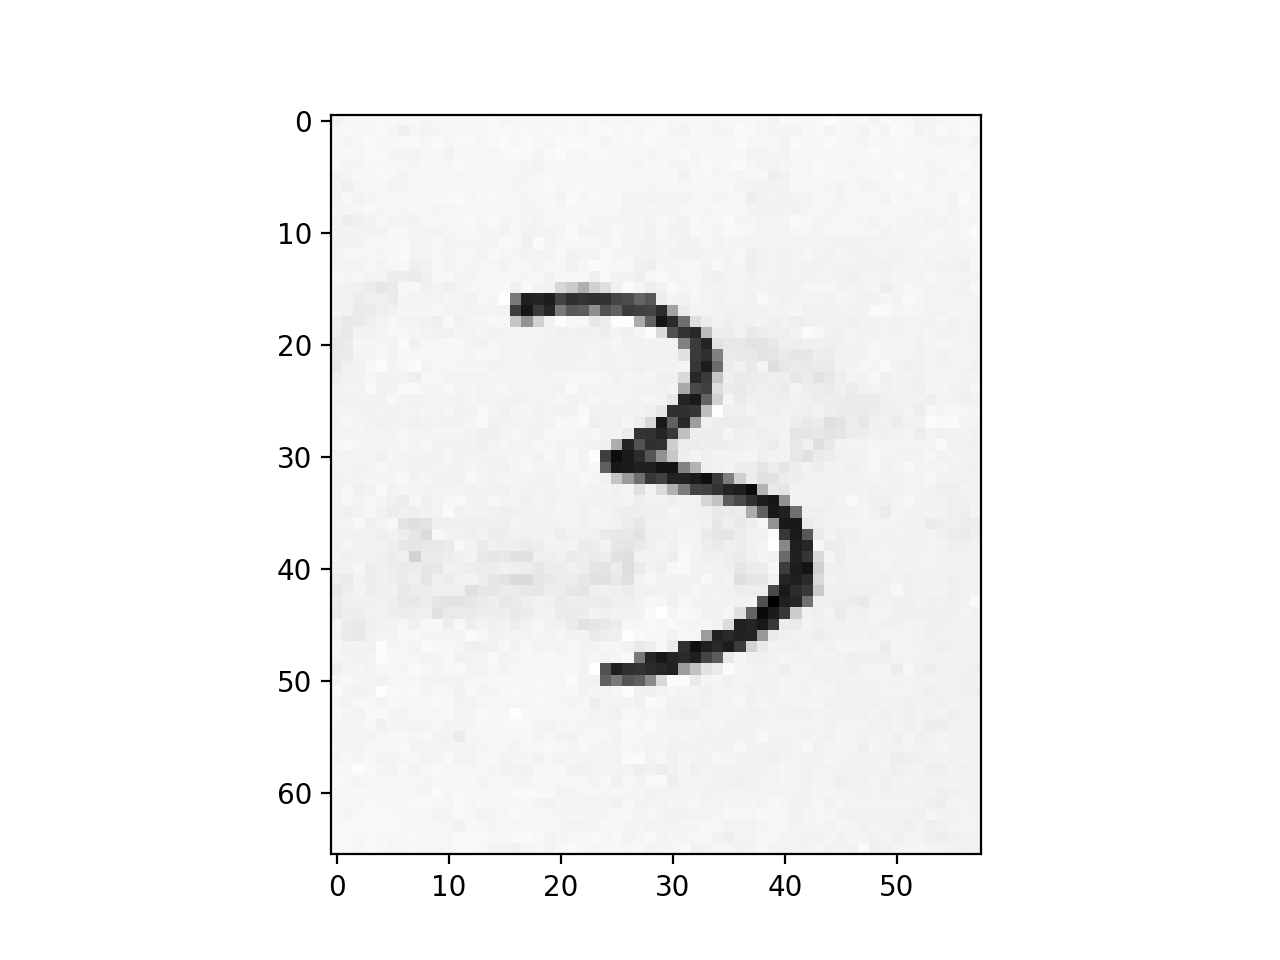

[305, 359, 115, 145]
[226, 278, 118, 165]
[156, 200, 130, 134]
[154, 201, 193, 238]
[312, 355, 210, 248]
[230, 268, 226, 235]
[164, 198, 310, 336]
[233, 258, 310, 334]
[307, 353, 321, 346]


In [114]:
img = plt.imread("Test_Numbers.jpg")
# print(img.shape)
new_img = rgb_to_grayscale(img)
new_img = new_img.T[...,::-1]
(nrows, ncols) = new_img.shape
if (nrows > 500):
    new_img = cv2.resize(new_img, (500, nrows))
(nrow, ncols) = new_img.shape
if (nrows > 500):
    new_img = cv2.resize(new_img, (ncols, 500))
plt.imshow(new_img, cmap = "gray")
subimages = floodfill(new_img, high_cutoff=100)
for subimage in subimages:
    print(subimage)
    subimage[0] -= 16
    subimage[1] += 16
    subimage[2] -= 16
    subimage[3] += 16
answers = []
for subimage in subimages:
    answers.append(new_img[subimage[0]:subimage[1],subimage[2]:subimage[3]])


In [115]:
# plt.imshow(new_img, cmap = "gray")
plt.imshow(answers[6], cmap = "gray")

In [116]:
print(answers[0])

[[179.72823405 180.76159979 180.8912228  ... 181.5142648  184.06201
  182.37189103]
 [178.13519362 180.248512   180.51481244 ... 183.07606741 182.06361786
  182.9781184 ]
 [179.6752156  180.0925276  181.1772262  ... 184.47629537 183.98168203
  183.3180844 ]
 ...
 [177.54126902 179.07491625 179.1224848  ... 179.35776047 178.822534
  179.6184544 ]
 [177.94289285 179.80135571 179.5151104  ... 180.6503512  179.858332
  179.298388  ]
 [179.97801732 178.75053224 179.6459104  ... 180.6303532  179.055796
  178.74088349]]


In [21]:
import numpy as np
import mygrad as mg
from mygrad import Tensor

from noggin import create_plot
import matplotlib.pyplot as plt

%matplotlib notebook
import cv2

### MNIST Data Loading and preprocessing

First, we will load in our data using handy functions from the datasets repo. If you haven't already, download the data by calling `download_mnist()`


In [2]:
from datasets import load_mnist, download_mnist
download_mnist()

`datasets module: datasets will be loaded from '/Users/nadine/datasets'
Saving to: /Users/nadine/datasets/mnist.npz


In [3]:
# loading in the dataset with train/test data/labels
x_train, y_train, x_test, y_test = load_mnist()

mnist loaded


What is the shape and data-types of these arrays? What is the shape of each individual image? How many color-channels does each number have.



Let's plot some examples from the MNIST dataset below


<IPython.core.display.Javascript object>


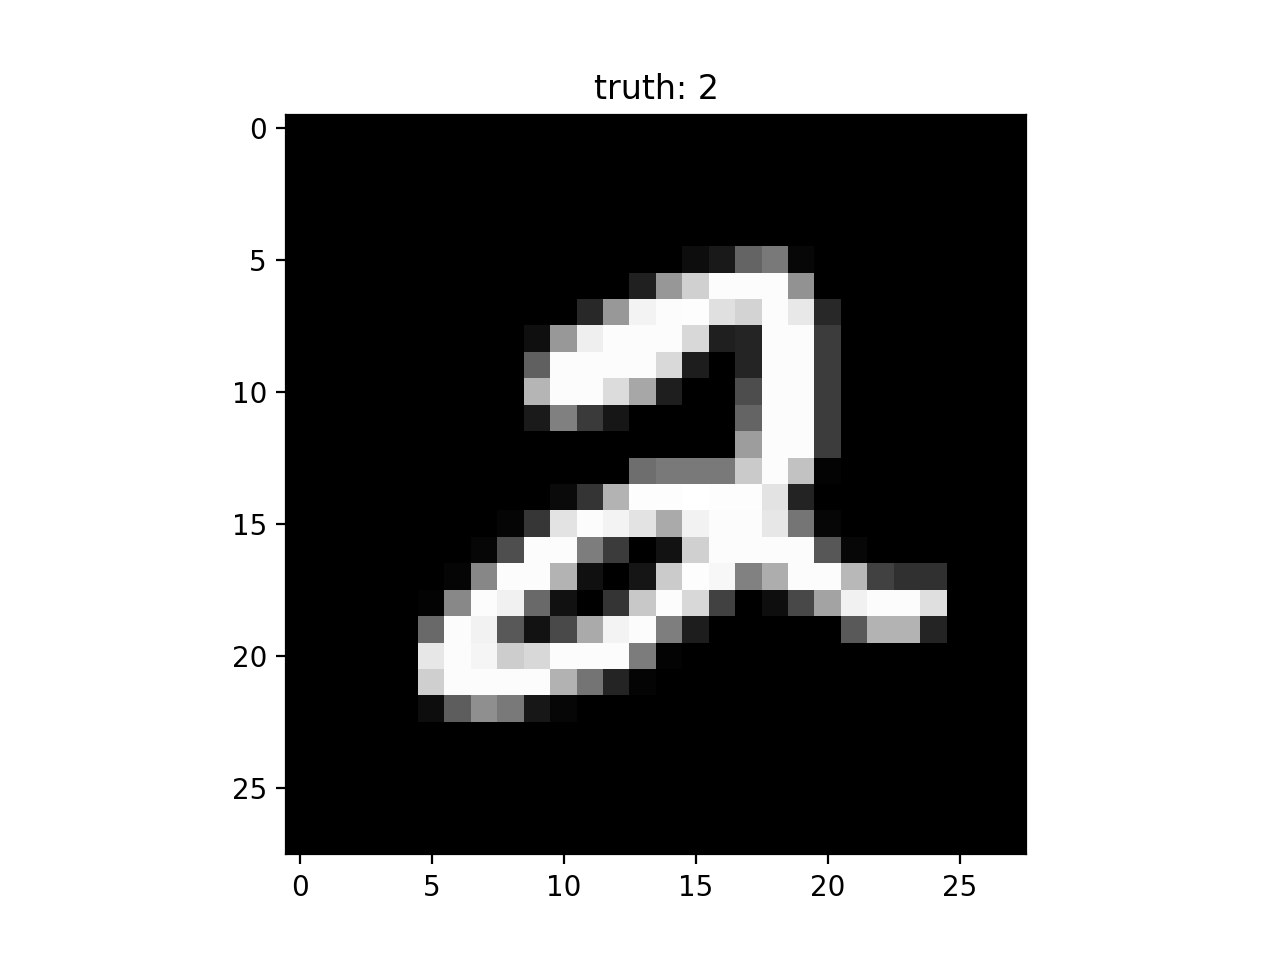

In [4]:
img_id = 5

fig, ax = plt.subplots()
ax.imshow(x_train[img_id, 0], cmap="gray")
ax.set_title(f"truth: {y_train[img_id]}");

We will want to turn these 28x28 images into 32x32 images, for the sake of compatibility with the convolutions that we want to do. We can simply pad two rows/columns of zeros to all sides of the images


In [5]:
# zero-pad the images
x_train = np.pad(x_train, ((0, 0), (0, 0), (2, 2), (2, 2)), mode="constant")
x_test = np.pad(x_test, ((0, 0), (0, 0), (2, 2), (2, 2)), mode="constant")

The original images stored unsigned 8bit integers for their pixel values. We need to convert these to floating-point values. Let's convert the images (not the labels) 32-bit floats.
You can use the `.astype()` array method to do this, and specify either `np.float32` or `"float32"` in the method call.


In [6]:
# <COGINST>
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
# </COGINST>

Finally, we need to normalize these images. With cifar-10, we shifted the images by the mean and divided by the standard deviation. Here, let's be a little laze and simply normalize the images so that their pixel values lie on $[0, 1]$


In [7]:
# <COGINST>
x_train /=  255.
x_test /= 255.

print(x_test.shape)
# </COGINST>

(10000, 1, 32, 32)


Complete the following classification accuracy function.

In [8]:
def accuracy(predictions, truth):
    """
    Returns the mean classification accuracy for a batch of predictions.
    
    Parameters
    ----------
    predictions : Union[numpy.ndarray, mg.Tensor], shape=(M, D)
        The scores for D classes, for a batch of M data points

    truth : numpy.ndarray, shape=(M,)
        The true labels for each datum in the batch: each label is an
        integer in [0, D)
    
    Returns
    -------
    float
        The fraction of predictions that indicated the correct class.
    """
    # <COGINST>
    if isinstance(predictions, mg.Tensor):
        predictions = predictions.data
    return np.mean(np.argmax(predictions, axis=1) == truth)
    # </COGINST>

## The "LeNet" Architecture


In the convnet to classify MNIST images, we will construct a CNN with two convolutional layers each structured as: 

```
conv layer --> relu --> pooling layer
```

, followed by two dense layers with a relu between them. Thus our network is:

```
CONV -> RELU -> POOL -> CONV -> RELU -> POOL -> FLATTEN -> DENSE -> RELU -> DENSE -> SOFTMAX
```



### Layer Details

CONV-1: 20 filters, 5x5 filter size, stride-1

POOL-1: 2x2, stride-2

CONV-2: 10 filters, 5x5 filter size, stride-1

POOL-2: 2x2, stride-2

DENSE-3: 20 neurons

DENSE-4: size-???  # hint: what should the dimensionality of our output be?

### Activations

We will be using the "Glorot Uniform" initialization scheme for all of our layers' weights (the biases will be 0, which is the default). If you would like to read more about how Xavier Glorot explains the rationalization behind these weight initializations, look here for [his paper written with Yoshua Bengio](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf).

This initialization scheme takes an additional "gain parameter", which will be $\sqrt{2}$ for us. Use the following syntax for specifying this gain:

```python
from mygrad.nnet.initializers import glorot_uniform

gain = {'gain': np.sqrt(2)}

# E.g. initializing a dense layer with glorot-uniform initialization
# and a gain of root-2
dense(d1, d2, 
      weight_initializer=glorot_uniform, 
      weight_kwargs=gain)
```

In [9]:
from mynn.layers.conv import conv
from mynn.layers.dense import dense

from mygrad.nnet.initializers import glorot_uniform
from mygrad.nnet.activations import relu
from mygrad.nnet.layers import max_pool
from mygrad.nnet.losses import softmax_crossentropy

In [10]:
# Define your `Model`-MyNN class for the architecture prescribed above.

class Model:
    ''' A simple convolutional neural network. '''
    def __init__(self, num_input_channels, f1, f2, d1, num_classes):
        """
        Parameters
        ----------
        num_input_channels : int
            The number of channels for a input datum
            
        f1 : int
            The number of filters in conv-layer 1
        
        f2 : int
            The number of filters in conv-layer 2

        d1 : int
            The number of neurons in dense-layer 1
        
        num_classes : int
            The number of classes predicted by the model.
        """
        # Initialize your two convolution layers and two dense layers each 
        # as class attributes using the functions imported from MyNN
        #
        # We will use `weight_initializer=glorot_uniform` for all 4 layers
        
        # Note that you will need to compute `input_size` for
        # dense layer 1 : the number of elements being produced by the preceding conv
        # layer
        # <COGINST>
        init_kwargs = {'gain': np.sqrt(2)}
        self.conv1 = conv(num_input_channels, f1, 5, 5, 
                          weight_initializer=glorot_uniform, 
                          weight_kwargs=init_kwargs)
        self.conv2 = conv(f1, f2, 5, 5 ,
                          weight_initializer=glorot_uniform, 
                          weight_kwargs=init_kwargs)
        self.dense1 = dense(f2 * 5 * 5, d1, 
                            weight_initializer=glorot_uniform, 
                            weight_kwargs=init_kwargs)
        self.dense2 = dense(d1, num_classes, 
                            weight_initializer=glorot_uniform, 
                            weight_kwargs=init_kwargs)
        # </COGINST>


    def __call__(self, x):
        ''' Defines a forward pass of the model.
        
        Parameters
        ----------
        x : numpy.ndarray, shape=(N, 1, 32, 32)
            The input data, where N is the number of images.
            
        Returns
        -------
        mygrad.Tensor, shape=(N, num_classes)
            The class scores for each of the N images.
        '''
        
        # Define the "forward pass" for this model based on the architecture detailed above.
        # Note that, to compute 
        # We know the new dimension given the formula: out_size = ((in_size - filter_size)/stride) + 1
    
        # <COGINST>
        x = relu(self.conv1(x))
        x = max_pool(x, (2, 2), 2)
        x = relu(self.conv2(x))
        x = max_pool(x, (2, 2), 2)
        x = relu(self.dense1(x.reshape(x.shape[0], -1)))
        return self.dense2(x)
        # </COGINST>

    @property
    def parameters(self):
        """ A convenience function for getting all the parameters of our model. """
        # Create a list of every parameter contained in the 4 layers you wrote in your __init__ function
        # <COGINST>
        params = []
        for layer in (self.conv1, self.conv2, self.dense1, self.dense2):
            params += list(layer.parameters)
        return params
        # </COGINST>


Initialize the SGD-optimizer. We will be adding a new feature to our update method, known as ["momentum"](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Momentum). The following is a sensible configuration for the optimizer:

```python
SGD(<your model parameters>, learning_rate=0.01, momentum=0.9, weight_decay=5e-04)
```

In [11]:
# Import SGD and initialize it as described above
# Also initialize your model
# <COGINST>
from mynn.optimizers.sgd import SGD

model = Model(f1=20, f2=10, d1=20, num_input_channels=1, num_classes=10)
optim = SGD(model.parameters, learning_rate=0.01, momentum=0.9, weight_decay=5e-04)
# </COGINST>

<IPython.core.display.Javascript object>


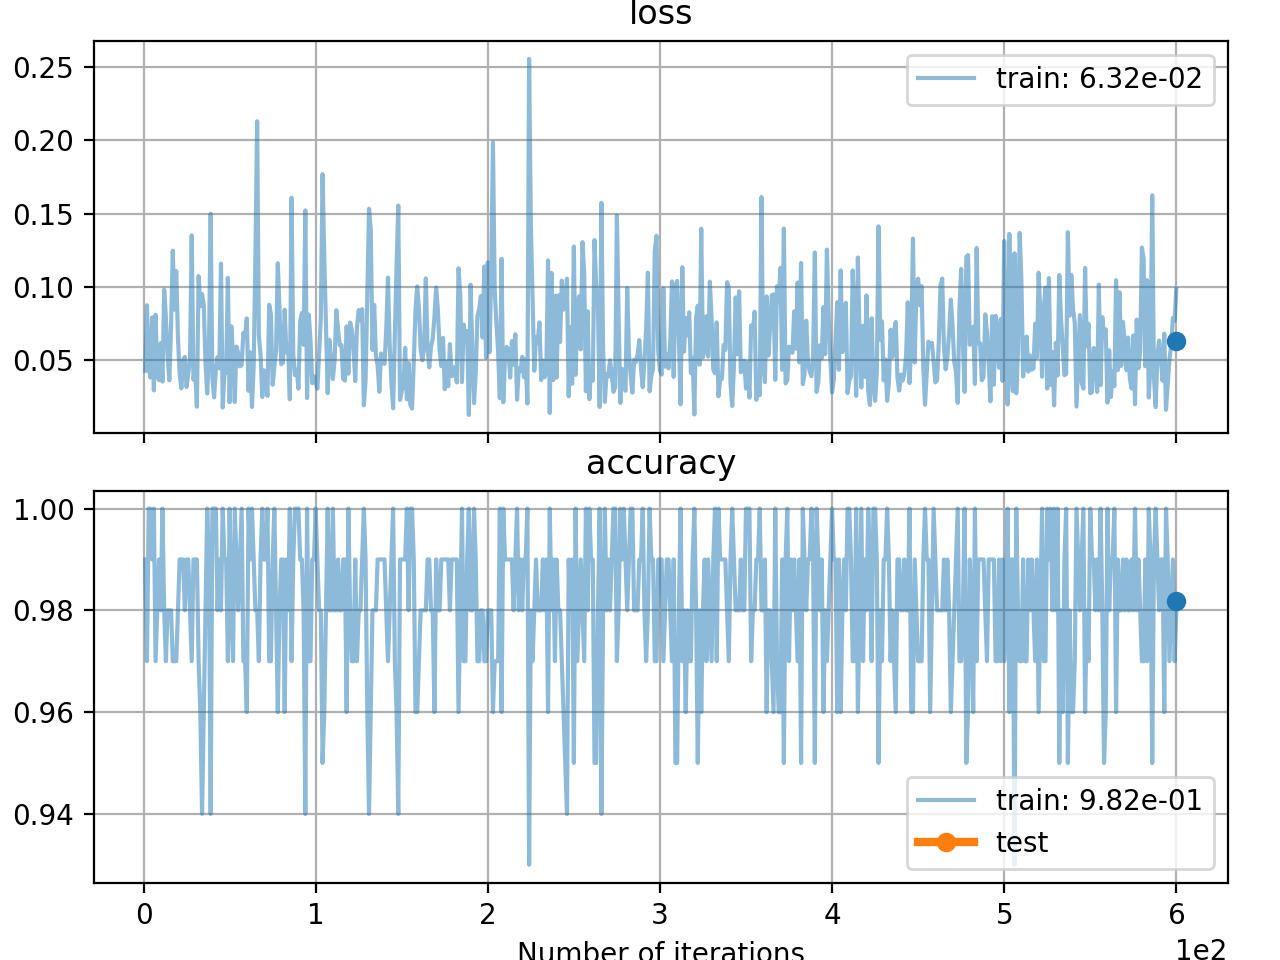

In [27]:
plotter, fig, ax = create_plot(["loss", "accuracy"])

Using a batch-size of 100, train your convolutional neural network. Try running through 1 epoch of your data (i.e. enough batches to have processed your entire training data set once) - this may take a while. Plot training-loss and training accuracy, via noggin, for each batch. After each epoch, measure the *test* accuracy of your model on the entire test set - do not perform backprop for this stage. You should find that your network gets excellent performance.

Reference the cifar-10 (solution) notebook for guidance on this.

In [28]:
# <COGINST>
batch_size = 100

# We will train for ~10 epochs; you can change this if you'd like
for epoch_cnt in range(1):
    idxs = np.arange(len(x_train))  # -> array([0, 1, ..., 9999])
    np.random.shuffle(idxs)  
    
    for batch_cnt in range(len(x_train)//batch_size):
        batch_indices = idxs[batch_cnt*batch_size : (batch_cnt + 1)*batch_size]
        batch = x_train[batch_indices]  # random batch of our training data

        # compute the predictions for this batch by calling on model
        prediction = model(batch)

        # compute the true (a.k.a desired) values for this batch: 
        truth = y_train[batch_indices]

        # compute the loss associated with our predictions(use softmax_cross_entropy)
        loss = softmax_crossentropy(prediction, truth)

        # back-propagate through your computational graph through your loss
        loss.backward()

        # compute the accuracy between the prediction and the truth 
        acc = accuracy(prediction, truth)

        # execute gradient descent by calling step() of optim
        optim.step()
        
        # null your gradients (please!)
        loss.null_gradients()
        
        # set the training loss and accuracy
        plotter.set_train_batch({"loss" : loss.item(),
                                 "accuracy" : acc},
                                 batch_size=batch_size)
    
    # Here, we evaluate our model on batches of *testing* data
    # this will show us how good our model does on data that 
    # it has never encountered
    # Iterate over batches of *testing* data
    for batch_cnt in range(0, len(x_test)//batch_size):
        idxs = np.arange(len(x_test))
        batch_indices = idxs[batch_cnt*batch_size : (batch_cnt + 1)*batch_size]
        batch = x_test[batch_indices] 
        
        # get your model's prediction on the test-batch
        prediction = model(batch)
        # get the truth values for that test-batch
        truth = y_test[batch_indices]
        # compute the test accuracy
        acc = accuracy(prediction, truth)
        
        # DO NOT back-prop or do gradient descent!
        
        # log the test-accuracy in noggin
        plotter.set_test_batch({"accuracy": acc}, batch_size=batch_size)
    
    plotter.set_train_epoch()
    plotter.set_test_epoch()
# </COGINST>

Referencing the matplotlib code at the top of the notebook, visualize some images and check your model's predictions for them.

Also, use your model and the truth data to find images that the model *fails* to get right - plot some of these fail cases.

In [ ]:
# <COGLINE>
from PIL import Image
im = Image.open("greyscalecry.png")
print(im)

test_time = np.pad(finaltest, ((0, 0), (0, 0), (2, 2), (2, 2)), mode="constant")

In [29]:
import numpy as np
import cv2
from PIL import Image

In [110]:
def convert_image(imgs):
    """
    Parameters
            ----------
            imgs : list
                matthew's output


    Output
            ----------
            new_imgs : np.array
                The (N, 1, 32, 32) of images to go into the model

    """
    N = len(imgs)
    convert_imgs = np.empty((N, 1, 32, 32))
    for i, j in enumerate(imgs):
        #change to 32 x 32
        print(j)
        img = cv2.resize(j, (32,32))
        print(img)
        #add the 1 at the beginning
        img = img[np.newaxis]
        convert_imgs[i] = img
    
    #typecast to float32
    convert_imgs = convert_imgs.astype(np.float32)
    convert_imgs = 255 - convert_imgs
    #normalize all data
    #print(convert_imgs)
    convert_imgs /=  255.
    #print(convert_imgs)
    return convert_imgs

In [117]:
p = convert_image(answers)


[[179.72823405 180.76159979 180.8912228  ... 181.5142648  184.06201
  182.37189103]
 [178.13519362 180.248512   180.51481244 ... 183.07606741 182.06361786
  182.9781184 ]
 [179.6752156  180.0925276  181.1772262  ... 184.47629537 183.98168203
  183.3180844 ]
 ...
 [177.54126902 179.07491625 179.1224848  ... 179.35776047 178.822534
  179.6184544 ]
 [177.94289285 179.80135571 179.5151104  ... 180.6503512  179.858332
  179.298388  ]
 [179.97801732 178.75053224 179.6459104  ... 180.6303532  179.055796
  178.74088349]]
[[179.29562608 180.59475067 180.1799241  ... 182.80140136 182.55285881
  182.64549128]
 [180.40392474 180.81654623 181.36441545 ... 184.24195905 182.79604947
  183.53641946]
 [180.83569325 181.88862217 180.54030739 ... 184.95613761 184.07133229
  183.81588121]
 ...
 [179.06952774 179.87179094 180.10038324 ... 177.63325236 180.40070561
  180.14873175]
 [177.808269   179.4850906  180.36284569 ... 178.27346887 181.31261931
  178.64289348]
 [178.90601394 179.15970594 179.37933846 

In [118]:
#test = x_train[img_id, 0]
#test = test[np.newaxis][np.newaxis]
#print(test.shape)

new_p = model(p).data

print(new_p)
#new_p = model(p).data

ID = [np.argmax(row) for row in new_p]
print(ID)

[[-0.8670731  -1.4431517  -1.1473917  -0.41657367  0.619904   -0.16888468
  -2.7873435   2.6172287   0.39474544  3.1156018 ]
 [ 2.325453   -1.4515733   0.6583276  -0.37565264 -2.3797355   0.6247218
   0.37689817 -1.9835271   1.1459577   1.2263811 ]
 [-1.1870395   4.4685206  -0.74769855 -1.1595685   0.61544657 -0.42561328
   0.0875554  -1.1205939   1.3713838  -1.7865833 ]
 [ 2.5792768  -1.4637679   0.54692066 -0.5395543  -2.303253    0.74257994
   0.69979626 -1.754991    0.84853894  0.7951409 ]
 [-2.2556715  -0.44570857 -1.3924619  -2.3072383   4.327314   -1.0330135
  -0.28062895  1.467636    0.7059635   1.2153304 ]
 [-2.2606645   3.9899154   0.3932415   0.16325983  0.58482724 -0.80779946
  -2.6212268   0.56111974  0.56671906 -0.4685061 ]
 [-1.55863    -0.3799746  -0.17309096  4.2764635  -0.77888036  0.4125741
  -1.6061033  -0.23585612  0.8062678  -0.56036276]
 [ 0.7098744   0.7985047   3.6538117   0.52616084 -2.8201418  -1.3402766
  -1.319438    0.57169557  1.1981429  -2.0643775 ]
 [ 1

In [119]:
import pickle
def save_model(self, path):
    """Path to .npz file where model parameters will be saved."""
    with open(path, "wb") as f:
        np.savez(f, *(x.data for x in self.parameters))

def load_model(self, path):
    with open(path, "rb") as f:
        for param, (name, array) in zip(self.parameters, np.load(f).items()):
            param.data[:] = array

In [121]:
save_model(model, "handwrite_digit_model.pkl")

In [ ]:
#img = plt.imread(i)
        #deal with the 4 channels
        #img = np.einsum("...hwc,c->...hw", img[...,:-1], [0.2989, 0.5870, 0.1140])
        
#imgs = ['1new.png']

#print(p.shape)
#print(p)